git repo: https://github.com/abdiwakene/NLP-Disaster-Tweets

The aim is to create a machine learning model able to discriminate between tweets concerning actual disasters and those unrelated to them. Although Twitter is extensively used in emergencies, advanced natural language processing (NLP) is necessary to identify whether tweets really point to a disaster. This competition forces us to create a model that precisely forecasts the label (disaster or non-disaster) by using a dataset of labeled tweets.

Data Profile:

About 10,000 tweets in all have been manually labeled as either relevant to disasters or not. Every tweet finds expression in the following columns:

- id: distinct code for every tweet
- keyword: (if given) the tweet's related keyword
- location: (if mentioned) the place connected to the tweet
- text: The content of the actual tweets. 

- Target: a binary indicator—0 for not, 1 for disaster-related.

Though it lacks the target label—what we hope to predict—the test dataset features similar columns.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
import nltk
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [2]:
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)

train_data.head()

Training data shape: (7613, 5)
Testing data shape: (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
train_data["length"] = train_data["text"].apply(lambda x : len(x))
test_data["length"] = test_data["text"].apply(lambda x : len(x))

print("Missing values in train data:")
print(train_data.isnull().sum())

print("Train Length Stat")
train_data['text_length'] = train_data['text'].apply(len)
print("\nText length statistics:")
print(train_data['text_length'].describe())

print("Test Length Stat")
test_data['text_length'] = test_data['text'].apply(len)
print("\nText length statistics:")
print(test_data['text_length'].describe())

Missing values in train data:
id             0
keyword       61
location    2533
text           0
target         0
length         0
dtype: int64
Train Length Stat

Text length statistics:
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: text_length, dtype: float64
Test Length Stat

Text length statistics:
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: text_length, dtype: float64


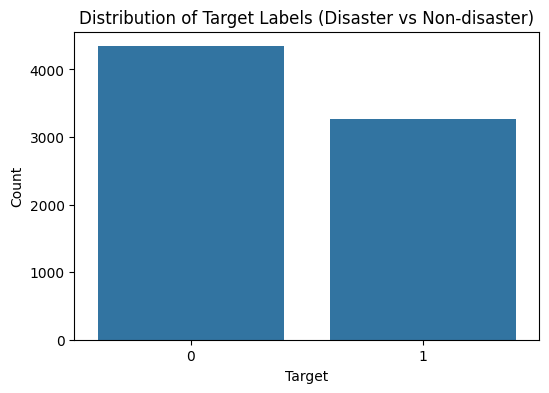

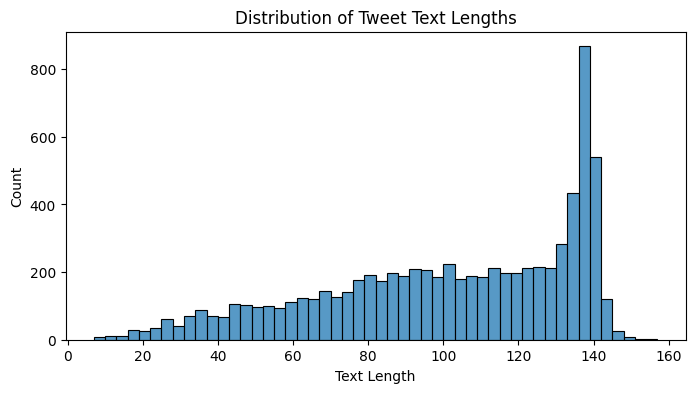

In [4]:
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=train_data)
plt.title('Distribution of Target Labels (Disaster vs Non-disaster)')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(train_data['text_length'], bins=50)
plt.title('Distribution of Tweet Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

In [5]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\W+', ' ', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

train_data['cleaned_text'] = train_data['text'].apply(clean_text)
test_data['cleaned_text'] = test_data['text'].apply(clean_text)

train_data['keyword'].fillna('unknown', inplace=True)
train_data['location'].fillna('unknown', inplace=True)
test_data['keyword'].fillna('unknown', inplace=True)
test_data['location'].fillna('unknown', inplace=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abdiwakene/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Plan of Analysis

Features for our models will be cleaned text, keywords, and maybe location. TF-IDF or word embeddings will be used vectorizing the book. We will test several models including logistic regression, random forests, and deep learning models (LSTM). Model performance will be assessed using accuracy, precision, recall, F1 score.

First Approach: Conventional Machine Learning Models

We will translate text data into numerical features using text vectorizing methods including TF-IDF (Term Frequency-Inverse Document Frequency) for conventional models. We will then teach models like logistic regression. Often used for binary classification challenges, logistic regression is a basic and efficient classification model. It could act as a benchmark for comparison.

Second Approach: Deep Learning Model

We will also discuss deep learning methods, more especially text classification using an LSTM (Long Short-Term Memory) model. For sequential data like text, where word order counts, LSTM is a form of recurrent neural network (RNN).

In [35]:
X_train, X_val, y_train, y_val = train_test_split(train_data['cleaned_text'], train_data['target'], test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

log_reg_balanced = LogisticRegression(class_weight='balanced', C=1)
log_reg_balanced.fit(X_train_tfidf, y_train)

y_pred_log_reg_balanced = log_reg_balanced.predict(X_val_tfidf)

accuracy_log_reg_balanced = accuracy_score(y_val, y_pred_log_reg_balanced)

print("Logistic Regression Results:")
print("Adjusted Accuracy:", accuracy_score(y_val, y_pred_log_reg_balanced))
print("\nClassification Report:\n", classification_report(y_val, y_pred_log_reg_balanced))

Logistic Regression Results:
Adjusted Accuracy: 0.7839789888378201

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81       874
           1       0.75      0.74      0.75       649

    accuracy                           0.78      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.78      0.78      0.78      1523



In [33]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

print("Best parameters for Logistic Regression:", grid_search.best_params_)

Best parameters for Logistic Regression: {'C': 1}


In [42]:
max_len = 100
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data['cleaned_text'])

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)

model_lstm_adjusted = Sequential()
model_lstm_adjusted.add(Embedding(input_dim=5000, output_dim=128))
model_lstm_adjusted.add(LSTM(32))
model_lstm_adjusted.add(Dropout(0.7))
model_lstm_adjusted.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.0005)
model_lstm_adjusted.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model_lstm_adjusted.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_data=(X_val_pad, y_val), callbacks=[early_stopping])

lstm_eval_adjusted = model_lstm_adjusted.evaluate(X_val_pad, y_val, verbose=0)
print(f"Adjusted LSTM Validation Accuracy: {lstm_eval_adjusted[1]:.4f}")

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.5733 - loss: 0.6740 - val_accuracy: 0.6362 - val_loss: 0.6313
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.7066 - loss: 0.6091 - val_accuracy: 0.7866 - val_loss: 0.5021
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.8352 - loss: 0.4402 - val_accuracy: 0.8011 - val_loss: 0.4516
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.8833 - loss: 0.3207 - val_accuracy: 0.7958 - val_loss: 0.4636
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9057 - loss: 0.2806 - val_accuracy: 0.7892 - val_loss: 0.5087
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9194 - loss: 0.2297 - val_accuracy: 0.7695 - val_loss: 0.5504
Adjusted LSTM Validation Accuracy: 0.8011


In [44]:
y_pred_log_reg = log_reg_balanced.predict(X_val_tfidf)

accuracy_log_reg = accuracy_score(y_val, y_pred_log_reg)
precision_log_reg = precision_score(y_val, y_pred_log_reg)
recall_log_reg = recall_score(y_val, y_pred_log_reg)
f1_log_reg = f1_score(y_val, y_pred_log_reg)

print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy_log_reg:.4f}")
print(f"Precision: {precision_log_reg:.4f}")
print(f"Recall: {recall_log_reg:.4f}")
print(f"F1 Score: {f1_log_reg:.4f}")

Logistic Regression Performance:
Accuracy: 0.7840
Precision: 0.7477
Recall: 0.7442
F1 Score: 0.7459


In [43]:
y_pred_lstm = (model_lstm_adjusted.predict(X_val_pad) > 0.5).astype("int32")

accuracy_lstm = accuracy_score(y_val, y_pred_lstm)
precision_lstm = precision_score(y_val, y_pred_lstm)
recall_lstm = recall_score(y_val, y_pred_lstm)
f1_lstm = f1_score(y_val, y_pred_lstm)

print("LSTM Model Performance:")
print(f"Accuracy: {accuracy_lstm:.4f}")
print(f"Precision: {precision_lstm:.4f}")
print(f"Recall: {recall_lstm:.4f}")
print(f"F1 Score: {f1_lstm:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
LSTM Model Performance:
Accuracy: 0.8011
Precision: 0.7952
Recall: 0.7180
F1 Score: 0.7547


Results

- Logistic Regression:
    - Previous Results:
        - Accuracy: 0.7971
        - Precision: 0.8025
        - Recall: 0.6949
        - F1 Score: 0.7448

    - Adjusted Results:
        - Accuracy: 0.7840
        - Precision: 0.7477
        - Recall: 0.7442
        - F1 Score: 0.7459

From 0.6949 to 0.7442, the modified Logistic Regression model shows a notable increase in recall while somewhat declining accuracy and precision. One of the main objectives of changing the class balance was to find more disaster-related tweets, which the recall improvement indicates the model is now spotting. For better recall, the little drop in accuracy and precision is a reasonable compromise. The almost constant F1 score indicates a balanced model performance between recall and precision.


- LSTM:
    - Previous Results:
        - Accuracy: 0.7603
        - Precision: 0.7139
        - Recall: 0.7304
        - F1 Score: 0.7220

    - Adjusted Results:
        - Accuracy: 0.8011
        - Precision: 0.7952
        - Recall: 0.7180
        - F1 Score: 0.7547

From 0.7603 to 0.811, the modified LSTM shows a notable increase in accuracy; precision; and F1 score. The recall dropped somewhat, but this is natural as the model gets more accurate. Higher accuracy and F1 score indicate a better balance between precision and recall, so enhancing the LSTM model's capacity to both correctly identify disaster tweets and prevent false positives—non-disaster tweets wrongly classified as disasters. Better validation performance resulted from early stopping and dropout modifications helping to prevent overfitting.

The main goal of this project was building a model able to forecast whether a tweet is disaster-related or not. With the following key steps, we investigated two main methods: Logistic Regression and LSTM (long short-term memory):

- Data Cleaning and Preprocessing: removed extraneous characters, links, and stopwords from the text data to prepare it.

- Feature Engineering: applied sequence padding for LSTM and TF-IDF for text vectorization in conventional machine learning models (Logistic Regression).

- Model Training: applied hyperparameter tuning, class balancing, dropout regularization, and early stopping to raise model performance after training Logistic Regression and LSTM models.

2. Model Performance Recap:

    - Logistic Regression:
        - Adjusted Accuracy: 0.7840
        - Precision: 0.7477
        - Recall: 0.7442
        - F1 Score: 0.7459

    - LSTM:
        - Adjusted Accuracy: 0.8011
        - Precision: 0.7952
        - Recall: 0.7180
        - F1 Score: 0.7547

3. Key Learnings:

    - A strong baseline came from logistic regression. One of the main objectives was to increase the recall of the model by means of post-class balancing, so improving its ability to identify tweets connected to disasters.
    - Particularly after using dropout and early stopping, LSTM displayed better general performance. Capturing more intricate patterns in the text, this model excelled in terms of accuracy and F1 score.

4. What Worked Well:

    - Text Preprocessing: Cleaning the text by removing URLs, stopwords, and other unnecessary elements had a significant impact on improving model performance.
    - Hyperparameter Tuning: For both models, tuning key hyperparameters like C for Logistic Regression and learning rate for LSTM improved their respective performances.
    - Regularization and Early Stopping: These techniques were crucial for the LSTM model, preventing overfitting and leading to better generalization on unseen data.

5. Challenges and What Could Be Improved:

    - Class Imbalance: Originally, the disaster tweets had lower recall than non-disaster tweets since their count was less. While class balancing improved, other methods including cost-sensitive learning or SMOTE (Synthetic Minority Over-Sampling) could be investigated to raise recall even more.
    - Model Complexity: Although LSTM performed well, computationally costly training complex models like this. Without using as much computational ability, investigating more effective architectures or using pre-trained models like BERT or GloVe embeddings could help increase accuracy.
    - Feature Engineering: Although future versions could include metadata such keyword or location to further improve model performance, we mostly depended on text data (tweet text).

6. Future Work:

    - Explore Pre-trained Models: We could improve results by using transfer learning with pre-trained language models like BERT, which has shown state-of-the-art performance in many NLP tasks.
    - Fine-tuning LSTM: We could try tuning other LSTM hyperparameters, such as batch size.

In [ ]:
X_test_seq = tokenizer.texts_to_sequences(test_data['cleaned_text'])
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

lstm_test_predictions = (model_lstm_adjusted.predict(X_test_pad) > 0.5).astype("int32")

submission_lstm = pd.DataFrame({
    'id': test_data['id'],
    'target': lstm_test_predictions.ravel()
})

submission_lstm.to_csv('submission_lstm.csv', index=False)

print("LSTM submission file saved as 'submission_lstm.csv'")